In [288]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Import as Dataframe
df = pd.read_excel('TimeSeries.xlsx', parse_dates=['Date'])
df.head()

,Date,Transaction,Count
0,2016-01-01,00:00:00,2093576
1,2016-02-01,00:00:00,2397260
2,2016-03-01,00:00:00,2173039
3,2016-04-01,00:00:00,2051240
4,2016-05-01,00:00:00,1954117


In [289]:
df.drop('Transaction',axis=1, inplace=True)

In [290]:
df.head()

,Date,Count
0,2016-01-01,2093576
1,2016-02-01,2397260
2,2016-03-01,2173039
3,2016-04-01,2051240
4,2016-05-01,1954117


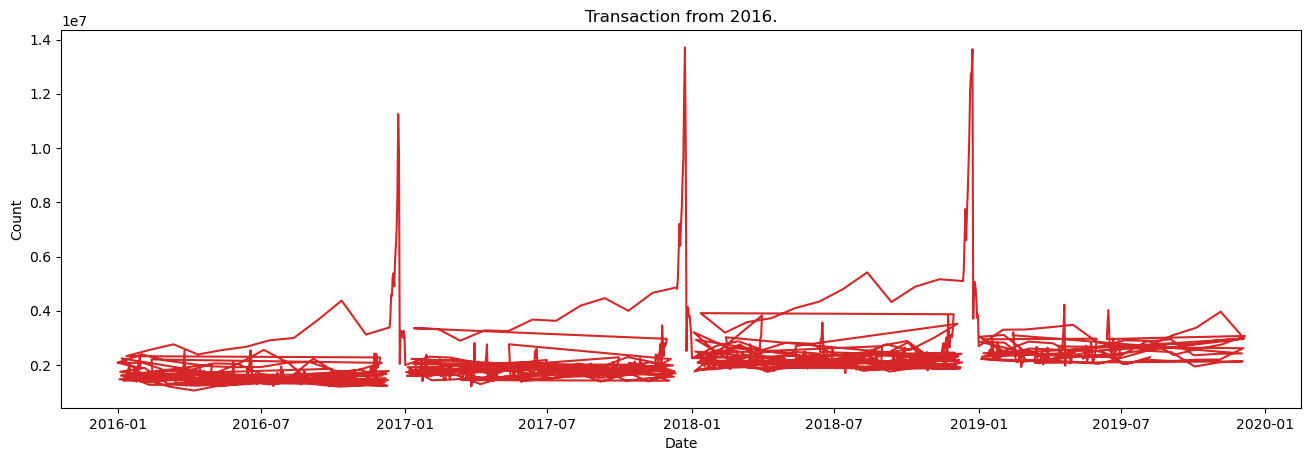

In [291]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Count', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Date, y=df.Count, title='Transaction from 2016.')    

daily trasation plot is too granual.. though from the plot it looks its seasonal. Would like to analyse monthly chart.. that may provide different picture for seasonality

In [320]:
transactions = df.groupby(df['Date'].dt.strftime('%m-%Y'))['Count'].sum()
transactions.index = pd.to_datetime(transactions.index)

In [293]:
transactions=transactions.sort_index().to_frame()

In [294]:
transactions

,Count
Date,
2016-01-01,54954027
2016-02-01,58548465
2016-03-01,69957402
2016-04-01,65111523
2016-05-01,47661978
2016-06-01,50618870
2016-07-01,63622715
2016-08-01,57246711
2016-09-01,50721581


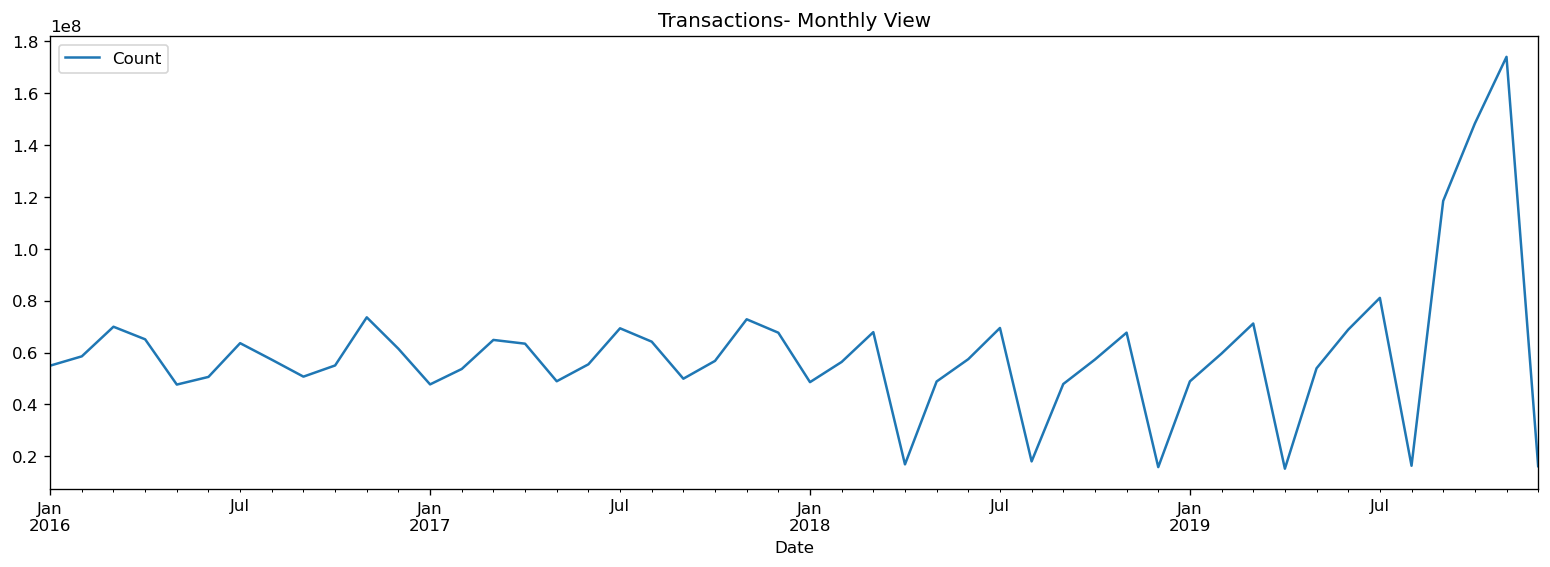

In [295]:
transactions.plot(title='Transactions- Monthly View',figsize= (16,5));

Season + trend quite visible uptil jul'19 but after that sudden drop.. also in jan'19-jul'19 the plot started lower then the trend..

Seasonality+trend breakdown.. analysing each seperately

In [296]:
from statsmodels.tsa.seasonal import seasonal_decompose

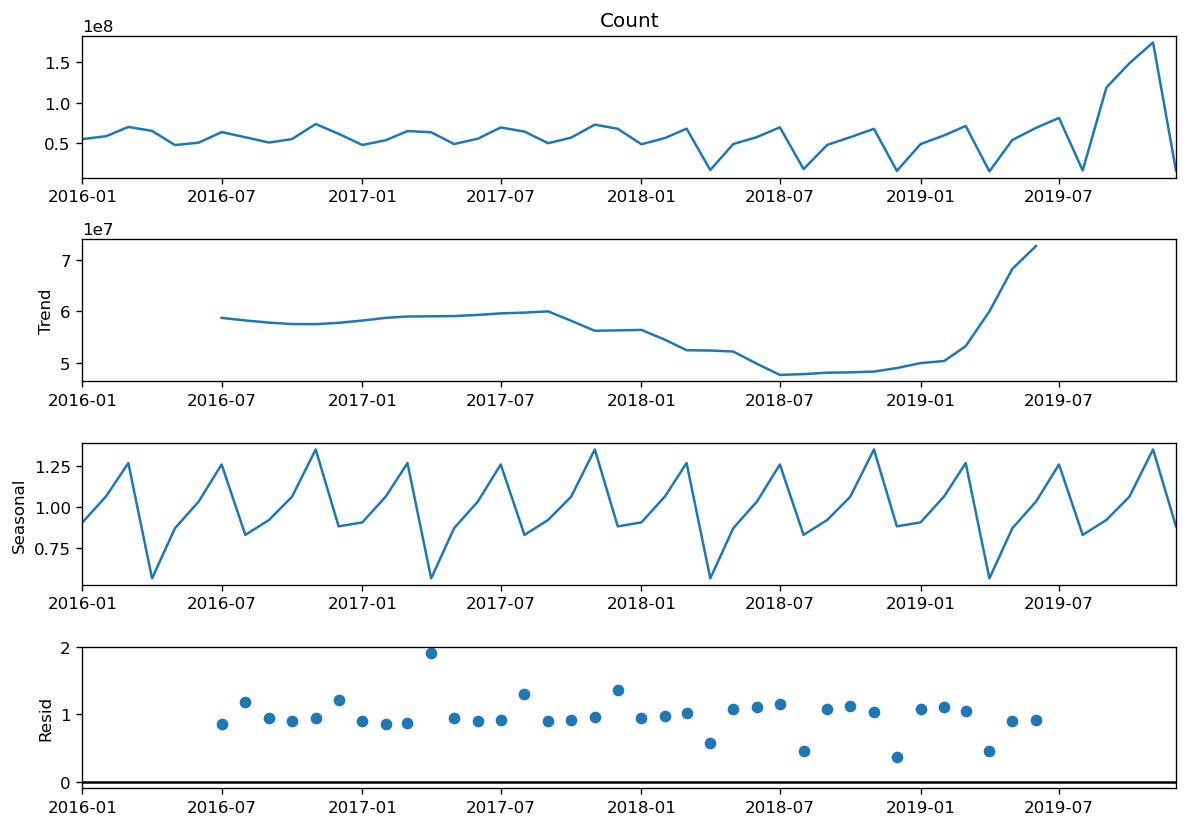

In [297]:
result = seasonal_decompose(transactions['Count'], model='multiplicative')  # model='mul' also works
result.plot();

Will try different models

___
# SMA
## Simple Moving Average


In [298]:
transactions['6-month-SMA'] = transactions['Count'].rolling(window=6).mean()
transactions['12-month-SMA'] = transactions['Count'].rolling(window=12).mean()

In [299]:
transactions.head(15)

,Count,6-month-SMA,12-month-SMA
Date,,,
2016-01-01,54954027,NaN,NaN
2016-02-01,58548465,NaN,NaN
2016-03-01,69957402,NaN,NaN
2016-04-01,65111523,NaN,NaN
2016-05-01,47661978,NaN,NaN
2016-06-01,50618870,5.780871e+07,NaN
2016-07-01,63622715,5.925349e+07,NaN
2016-08-01,57246711,5.903653e+07,NaN
2016-09-01,50721581,5.583056e+07,NaN


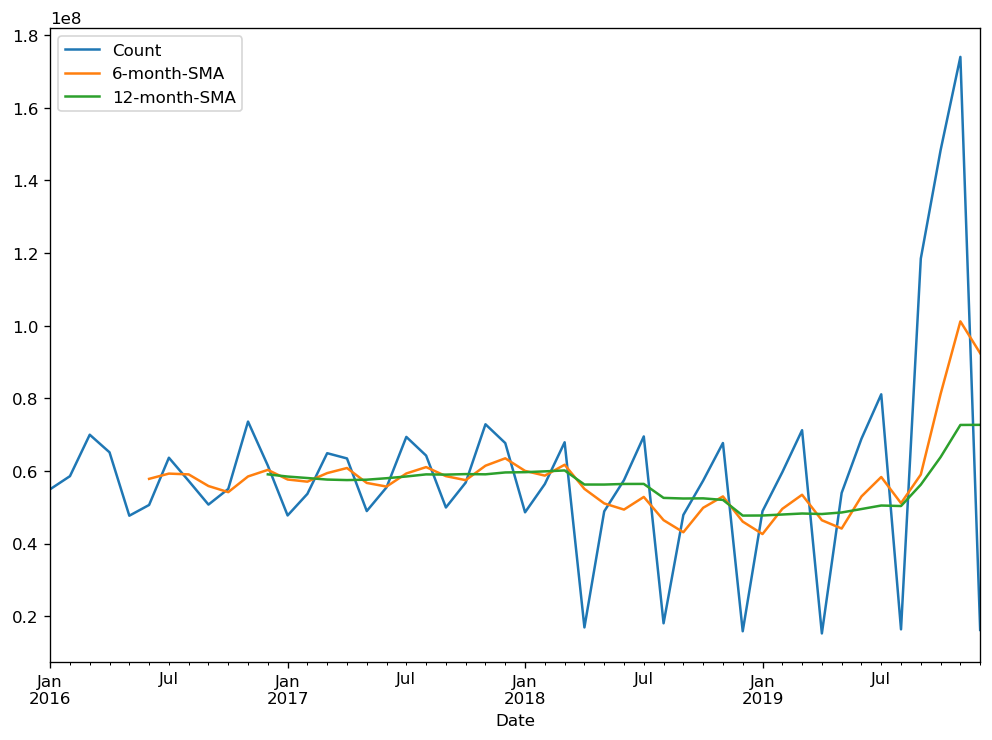

In [300]:
transactions.plot();

___
# EWMA
## Exponentially Weighted Moving Average 

Showing how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

some of these issues can be resolved

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [301]:
transactions['EWMA12'] = transactions['Count'].ewm(span=12,adjust=False).mean()

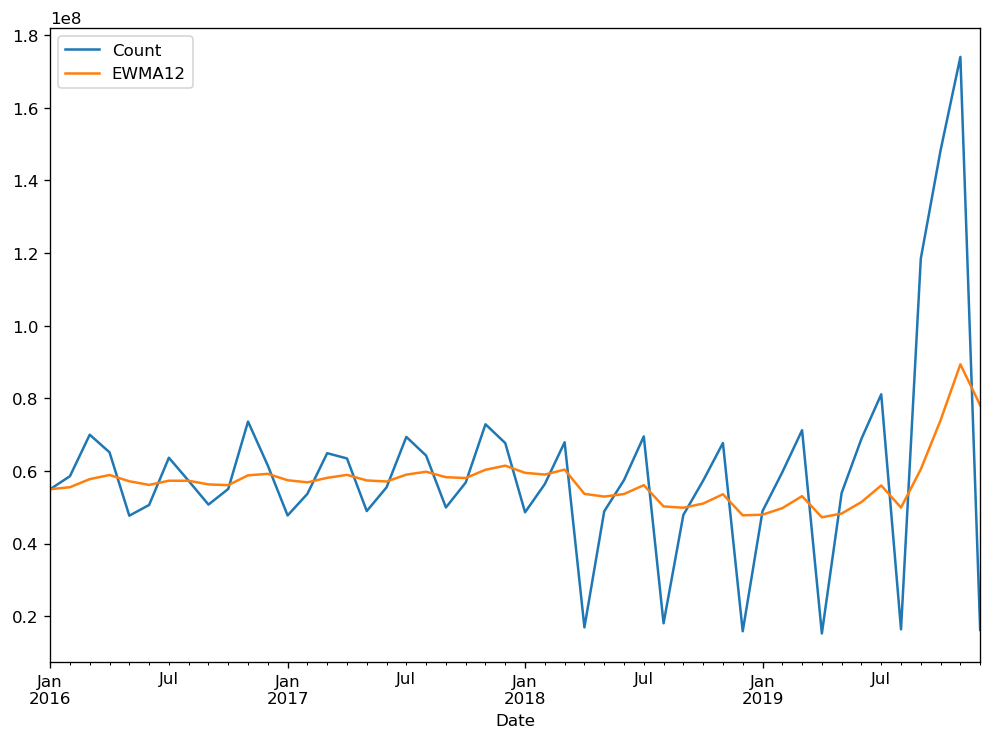

In [302]:
transactions[['Count','EWMA12']].plot();

## Comparing SMA to EWMA

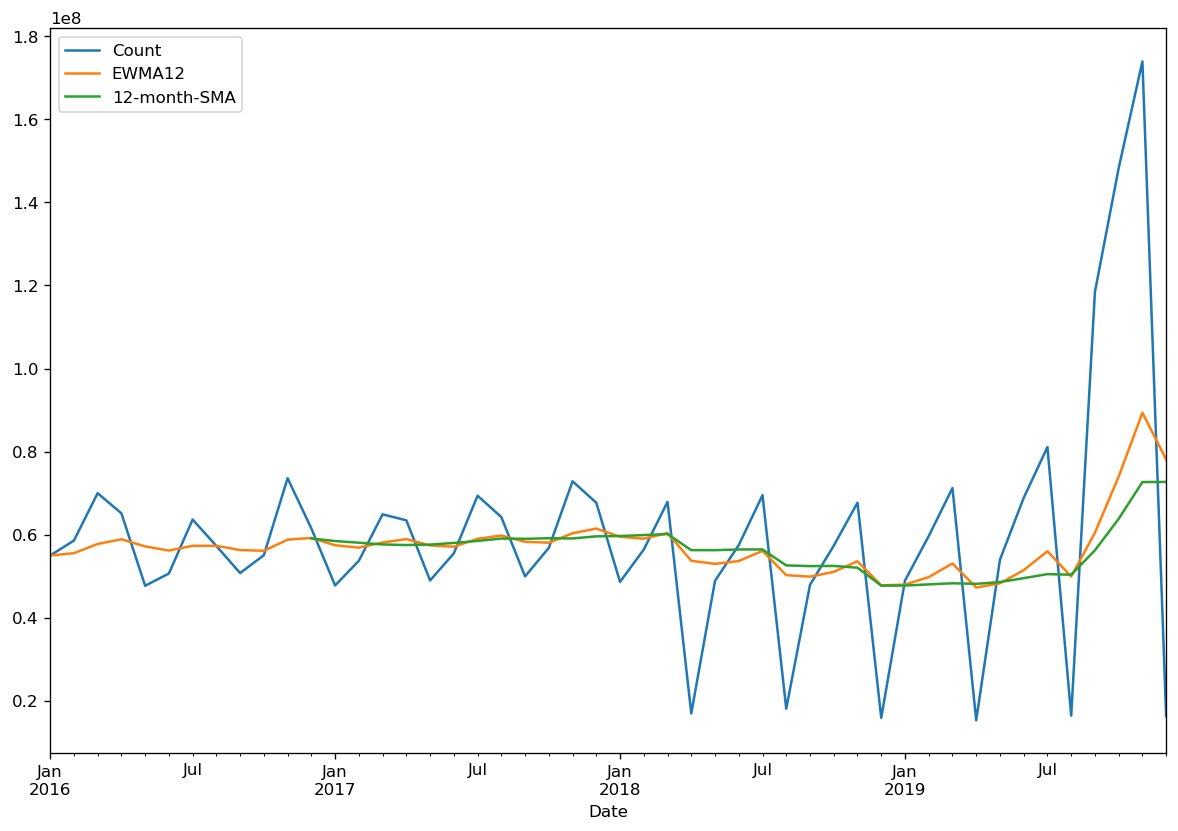

In [303]:
transactions[['Count','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Simple Exponential Smoothing
The above example employed <em>Simple Exponential Smoothing</em> with one smoothing factor <strong>α</strong>. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above. In the next section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the Holt-Winters Methods.

# Holt-Winters Methods
In the previous section on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
    
<h3>For Further Reading:</h3>
<tt>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc43.htm'>NIST/SEMATECH e-Handbook of Statistical Methods</a></strong>&nbsp;&nbsp;<font color=black>What is Exponential Smoothing?</font></tt></div>

In [304]:
transactions.head()

,Count,6-month-SMA,12-month-SMA,EWMA12
Date,,,,
2016-01-01,54954027,NaN,NaN,5.495403e+07
2016-02-01,58548465,NaN,NaN,5.550702e+07
2016-03-01,69957402,NaN,NaN,5.773015e+07
2016-04-01,65111523,NaN,NaN,5.886575e+07
2016-05-01,47661978,NaN,NaN,5.714209e+07


___
## Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [305]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

transactions['EWMA12'] = transactions['Count'].ewm(alpha=alpha,adjust=False).mean()
transactions['SES12']=SimpleExpSmoothing(transactions['Count']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
transactions.head()

C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


,Count,6-month-SMA,12-month-SMA,EWMA12,SES12
Date,,,,,
2016-01-01,54954027,NaN,NaN,5.495403e+07,5.495403e+07
2016-02-01,58548465,NaN,NaN,5.550702e+07,5.550702e+07
2016-03-01,69957402,NaN,NaN,5.773015e+07,5.773015e+07
2016-04-01,65111523,NaN,NaN,5.886575e+07,5.886575e+07
2016-05-01,47661978,NaN,NaN,5.714209e+07,5.714209e+07


In [306]:
transactions.drop(['6-month-SMA','12-month-SMA'],axis=1,inplace=True)

In [307]:
transactions.head()

,Count,EWMA12,SES12
Date,,,
2016-01-01,54954027,5.495403e+07,5.495403e+07
2016-02-01,58548465,5.550702e+07,5.550702e+07
2016-03-01,69957402,5.773015e+07,5.773015e+07
2016-04-01,65111523,5.886575e+07,5.886575e+07
2016-05-01,47661978,5.714209e+07,5.714209e+07


___
## Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [308]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

transactions['DESadd12'] = ExponentialSmoothing(transactions['Count'], trend='add').fit().fittedvalues.shift(-1)
transactions.head()

C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Count,EWMA12,SES12,DESadd12
Date,,,,
2016-01-01,54954027,5.495403e+07,5.495403e+07,6.131244e+07
2016-02-01,58548465,5.550702e+07,5.550702e+07,6.413360e+07
2016-03-01,69957402,5.773015e+07,5.773015e+07,6.883533e+07
2016-04-01,65111523,5.886575e+07,5.886575e+07,7.154938e+07
2016-05-01,47661978,5.714209e+07,5.714209e+07,6.946528e+07


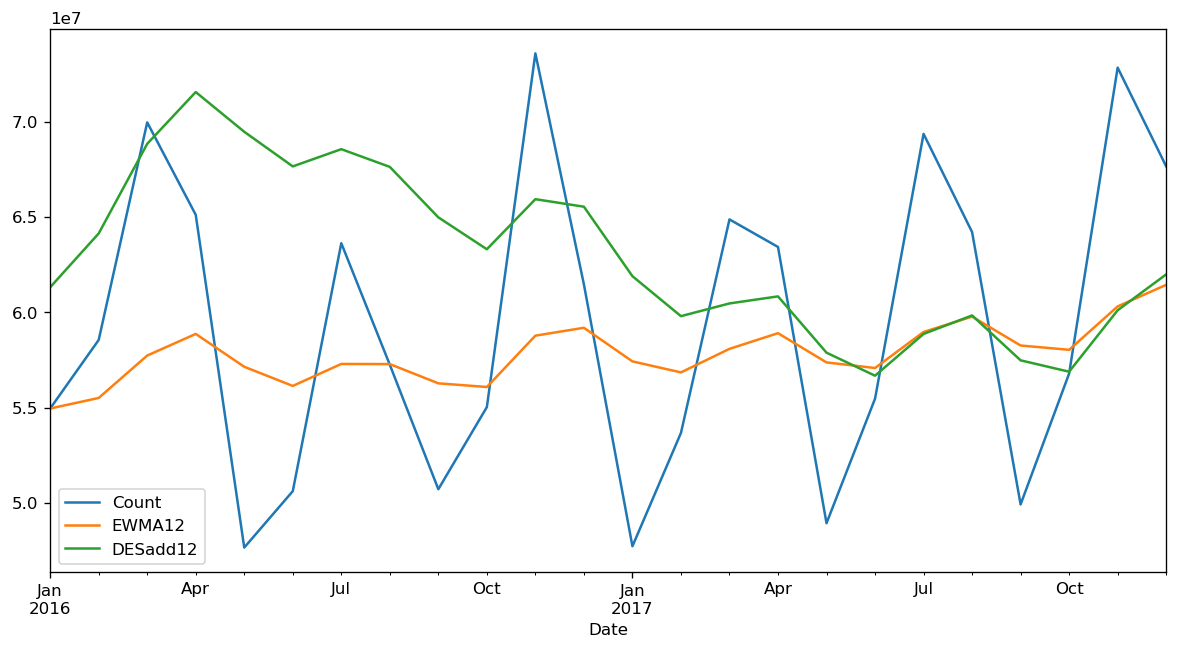

In [309]:
transactions[['Count','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.<br>
Let's see if using a multiplicative seasonal adjustment helps.

In [310]:
transactions['DESmul12'] = ExponentialSmoothing(transactions['Count'], trend='mul').fit().fittedvalues.shift(-1)
transactions.head()

C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Count,EWMA12,SES12,DESadd12,DESmul12
Date,,,,,
2016-01-01,54954027,5.495403e+07,5.495403e+07,6.131244e+07,6.161747e+07
2016-02-01,58548465,5.550702e+07,5.550702e+07,6.413360e+07,6.488287e+07
2016-03-01,69957402,5.773015e+07,5.773015e+07,6.883533e+07,6.997872e+07
2016-04-01,65111523,5.886575e+07,5.886575e+07,7.154938e+07,7.345582e+07
2016-05-01,47661978,5.714209e+07,5.714209e+07,6.946528e+07,7.262580e+07


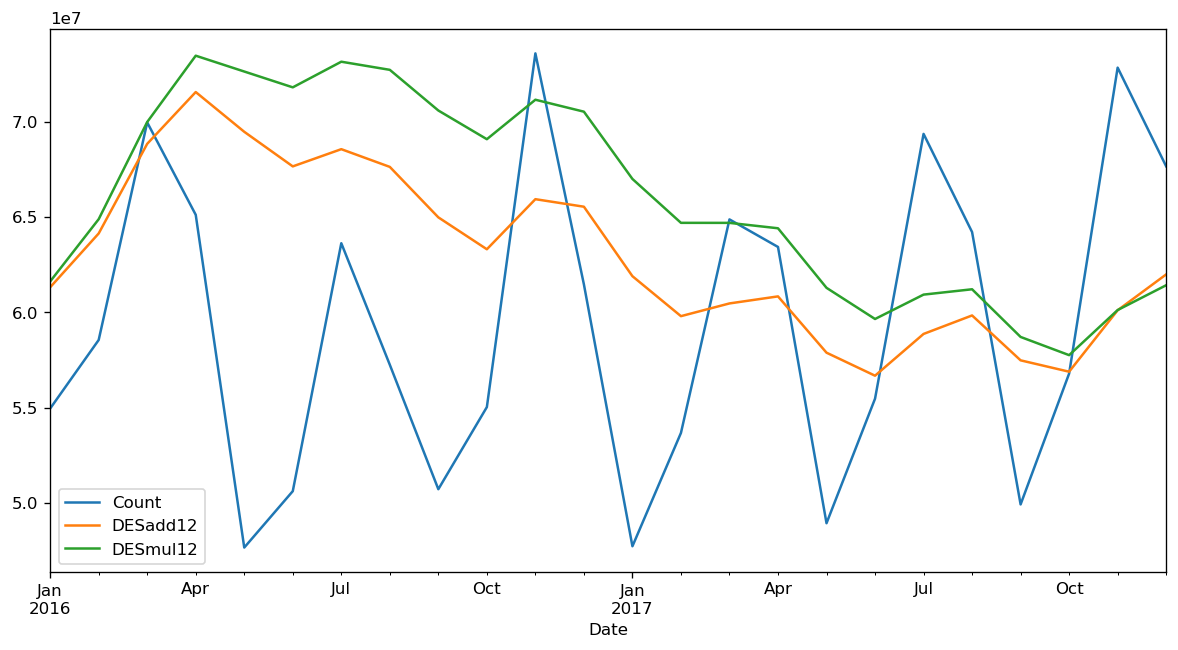

In [311]:
transactions[['Count','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

___
## Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [312]:
transactions['TESadd12'] = ExponentialSmoothing(transactions['Count'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
transactions.head()

C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Count,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Date,,,,,,
2016-01-01,54954027,5.495403e+07,5.495403e+07,6.131244e+07,6.161747e+07,5.499814e+07
2016-02-01,58548465,5.550702e+07,5.550702e+07,6.413360e+07,6.488287e+07,5.862721e+07
2016-03-01,69957402,5.773015e+07,5.773015e+07,6.883533e+07,6.997872e+07,7.006189e+07
2016-04-01,65111523,5.886575e+07,5.886575e+07,7.154938e+07,7.345582e+07,6.523361e+07
2016-05-01,47661978,5.714209e+07,5.714209e+07,6.946528e+07,7.262580e+07,4.779444e+07


In [313]:
transactions['TESmul12'] = ExponentialSmoothing(transactions['Count'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
transactions.head()

C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\singhs119\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Count,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Date,,,,,,,
2016-01-01,54954027,5.495403e+07,5.495403e+07,6.131244e+07,6.161747e+07,5.499814e+07,5.499492e+07
2016-02-01,58548465,5.550702e+07,5.550702e+07,6.413360e+07,6.488287e+07,5.862721e+07,5.862410e+07
2016-03-01,69957402,5.773015e+07,5.773015e+07,6.883533e+07,6.997872e+07,7.006189e+07,7.007354e+07
2016-04-01,65111523,5.886575e+07,5.886575e+07,7.154938e+07,7.345582e+07,6.523361e+07,6.523330e+07
2016-05-01,47661978,5.714209e+07,5.714209e+07,6.946528e+07,7.262580e+07,4.779444e+07,4.775476e+07


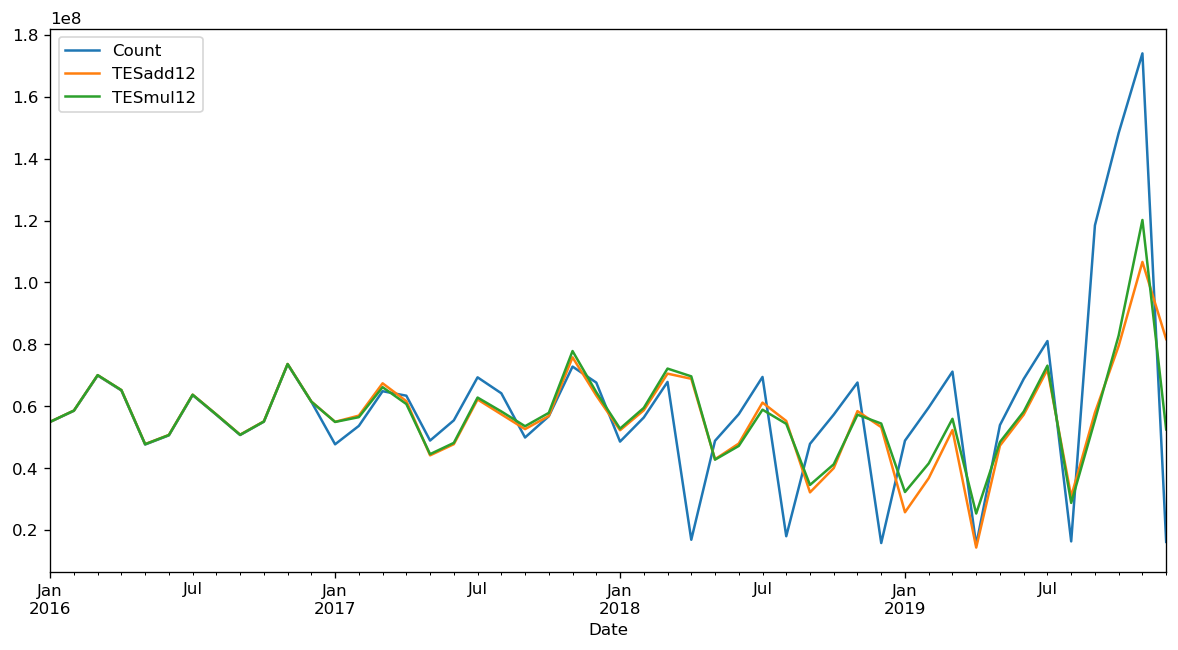

In [314]:
transactions[['Count','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

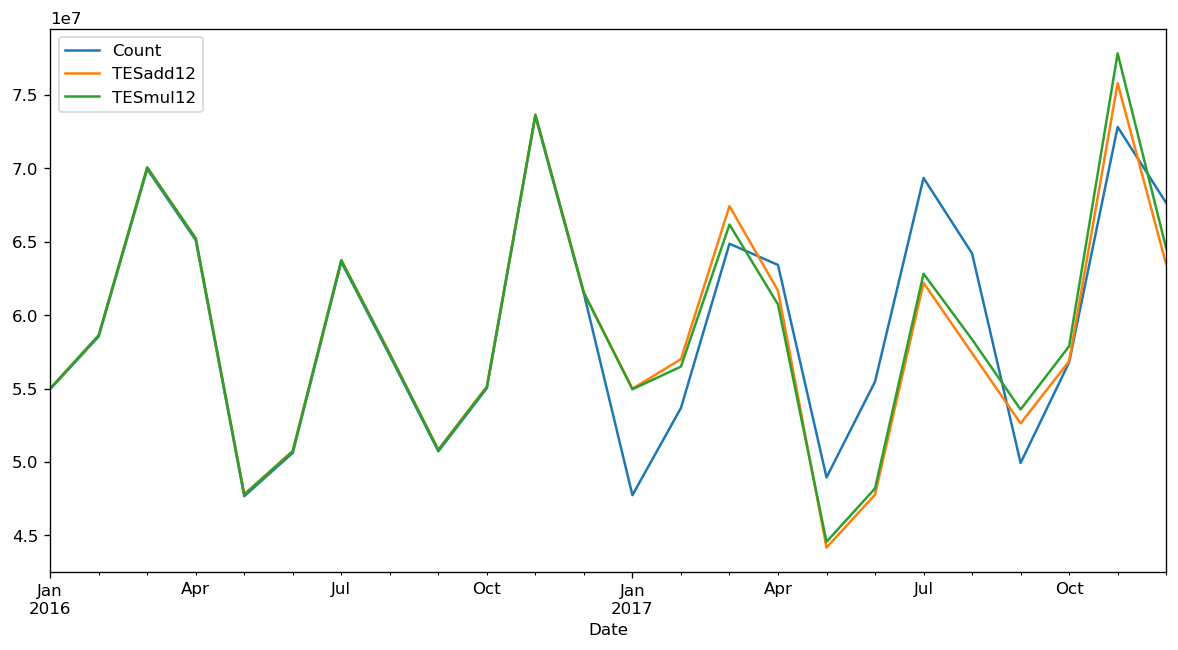

In [315]:
transactions[['Count','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);